In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from tensorflow.keras import utils 
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, SimpleRNN , LSTM, GRU, Masking
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [2]:
# Training
epochs = 40
batch_size = 1024

In [3]:
data = pd.read_excel('../data/отзывы за лето.xls')
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [4]:
data =  data.loc[data['Rating']!=3]
data.shape

(19748, 3)

In [5]:
conditions = [
(data['Rating'] < 3),    
(data['Rating'] > 3)]
choices = [0, 1]

data['Rating'] = np.select(conditions, choices, default = 5)

### Предобработка

In [6]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

data['Content'] = data['Content'].apply(preprocess_text)


train, test = train_test_split(data, test_size=0.6, shuffle=True, random_state=42)
valid, test = train_test_split(test, test_size=0.5, shuffle=True, random_state=42)

In [7]:
text_corpus_train = train['Content'].values
text_corpus_valid = valid['Content'].values
text_corpus_test = test['Content'].values

tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

x_train = pad_sequences(sequences_train, maxlen=training_length)
x_valid = pad_sequences(sequences_val, maxlen=training_length)
x_test = pad_sequences(sequences_test, maxlen=training_length)

y_train = train["Rating"].values
y_valid = valid["Rating"].values
y_test = test["Rating"].values

In [8]:
def plot_history (history):
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))

    ax[0].plot(history.history['loss'], label='train loss')
    ax[0].plot(history.history['val_loss'], label='validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(history.history['accuracy'], label='train accuracy')
    ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()

In [9]:
def build_train_predict_model (type_model,
                               x_train = x_train, 
                               y_train = y_train, 
                               x_valid = x_valid, 
                               y_valid = y_valid, 
                               x_test = x_test,
                               y_test = y_test,
                               epochs = epochs, 
                               batch_size = batch_size,
                               word_count = word_count,
                               training_length = training_length):
    
    
    model = Sequential()

    model.add(
        Embedding(input_dim=word_count,
                  input_length=training_length,
                  output_dim=30,
                  trainable=True,
                  mask_zero=True))
    model.add(Masking(mask_value=0.0))

    model.add(type_model(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile( optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping=EarlyStopping(monitor='val_loss')  


    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.1,
                        callbacks=[early_stopping])
    
    score = model.evaluate(x_valid, y_valid, batch_size=512, verbose=1)
    print(f'Test score: {round(score[0], 3)} \nTest accuracy: {round(score[0], 3)}')
    
    print('='*72)
    
    pred = model.predict(x_test)
    print(f'Test score: {round(roc_auc_score(y_test, pred),3)}')
    
    print('='*72)
    
    plot_history(history)

Epoch 1/40
7/7 [==============================] - 1s 141ms/step - loss: 0.5382 - accuracy: 0.7948 - val_loss: 0.4452 - val_accuracy: 0.8354
Epoch 2/40
7/7 [==============================] - 1s 120ms/step - loss: 0.4427 - accuracy: 0.8486 - val_loss: 0.4341 - val_accuracy: 0.8354
Epoch 3/40
7/7 [==============================] - 1s 108ms/step - loss: 0.4180 - accuracy: 0.8482 - val_loss: 0.3836 - val_accuracy: 0.8392
Epoch 4/40
12/12 [==============================] - 0s 22ms/step - loss: 0.3829 - accuracy: 0.8444
Test score: 0.383 
Test accuracy: 0.383
Test score: 0.885


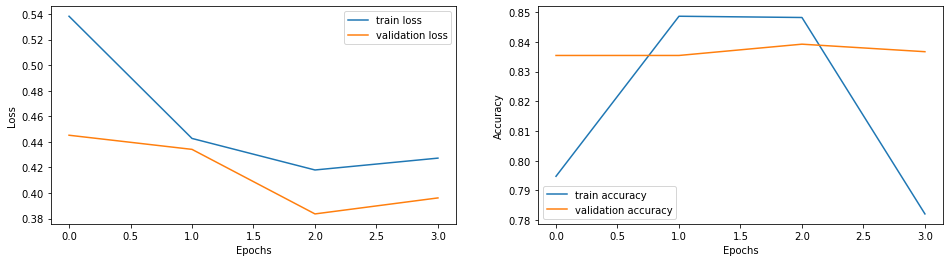

In [10]:
build_train_predict_model(type_model=SimpleRNN)

Epoch 1/40
7/7 [==============================] - 3s 394ms/step - loss: 0.6687 - accuracy: 0.8295 - val_loss: 0.6291 - val_accuracy: 0.8354
Epoch 2/40
7/7 [==============================] - 2s 316ms/step - loss: 0.5441 - accuracy: 0.8488 - val_loss: 0.4203 - val_accuracy: 0.8354
Epoch 3/40
7/7 [==============================] - 2s 320ms/step - loss: 0.4275 - accuracy: 0.8488 - val_loss: 0.4049 - val_accuracy: 0.8354
Epoch 4/40
7/7 [==============================] - 3s 369ms/step - loss: 0.3928 - accuracy: 0.8488 - val_loss: 0.3920 - val_accuracy: 0.8354
Epoch 5/40
7/7 [==============================] - 3s 388ms/step - loss: 0.3639 - accuracy: 0.8488 - val_loss: 0.3681 - val_accuracy: 0.8354
Epoch 6/40
7/7 [==============================] - 3s 391ms/step - loss: 0.3308 - accuracy: 0.8493 - val_loss: 0.3307 - val_accuracy: 0.8367
Epoch 7/40
7/7 [==============================] - 3s 392ms/step - loss: 0.2979 - accuracy: 0.8727 - val_loss: 0.3038 - val_accuracy: 0.8608
Epoch 8/40
7/7 [====

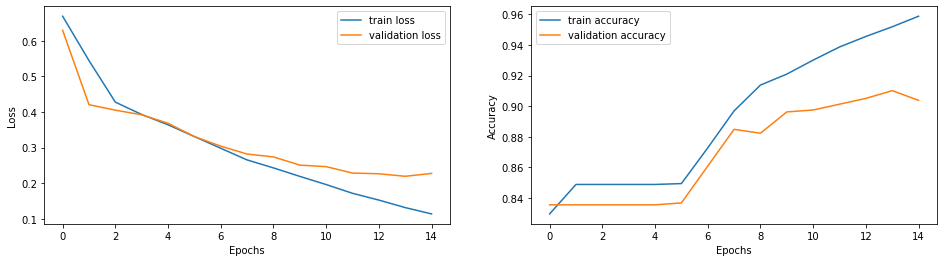

In [11]:
build_train_predict_model(type_model=LSTM)

Epoch 1/40
7/7 [==============================] - 2s 347ms/step - loss: 0.6645 - accuracy: 0.8298 - val_loss: 0.6233 - val_accuracy: 0.8354
Epoch 2/40
7/7 [==============================] - 2s 257ms/step - loss: 0.5730 - accuracy: 0.8488 - val_loss: 0.4989 - val_accuracy: 0.8354
Epoch 3/40
7/7 [==============================] - 2s 257ms/step - loss: 0.4261 - accuracy: 0.8488 - val_loss: 0.3918 - val_accuracy: 0.8354
Epoch 4/40
7/7 [==============================] - 2s 266ms/step - loss: 0.3734 - accuracy: 0.8488 - val_loss: 0.3738 - val_accuracy: 0.8354
Epoch 5/40
7/7 [==============================] - 2s 258ms/step - loss: 0.3312 - accuracy: 0.8488 - val_loss: 0.3406 - val_accuracy: 0.8354
Epoch 6/40
7/7 [==============================] - 2s 257ms/step - loss: 0.2983 - accuracy: 0.8488 - val_loss: 0.3092 - val_accuracy: 0.8354
Epoch 7/40
7/7 [==============================] - 2s 256ms/step - loss: 0.2535 - accuracy: 0.8553 - val_loss: 0.2903 - val_accuracy: 0.8494
Epoch 8/40
7/7 [====

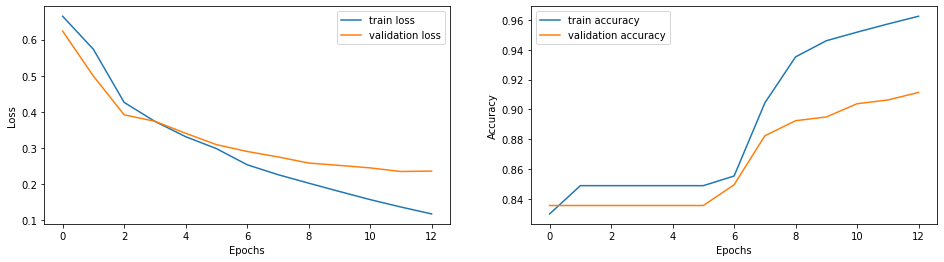

In [12]:
build_train_predict_model(type_model=GRU)